In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
from os.path import join
from tqdm import tqdm
import anndata
import scanpy as sc
sc.settings.set_figure_params(dpi=150)
import numpy as np
import pandas as pd
import seaborn as sns

/home/zhaoyy/miniconda3/envs/polyomino/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/zhaoyy/miniconda3/envs/polyomino/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/zhaoyy/miniconda3/envs/polyomino/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/zhaoyy/miniconda3/envs/polyomino/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/zhaoyy/miniconda3/envs/polyomino/lib/python3.10/site-packages/anndata/utils.py:434: 

In [4]:
import Polyomino as py

In [3]:
scdata = sc.read_h5ad('./jiazi_E15_5_sampled_30k.h5ad')

In [5]:
stdata = sc.read_h5ad('./Visium_HD_008um_binned.h5ad')

In [6]:
stdata

AnnData object with n_obs × n_vars = 344024 × 19070
    obs: 'in_tissue', 'array_row', 'array_col', 'y', 'x'
    var: 'gene_ids', 'feature_type'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
scdata.var_names_make_unique()

In [6]:
stdata.var_names_make_unique()

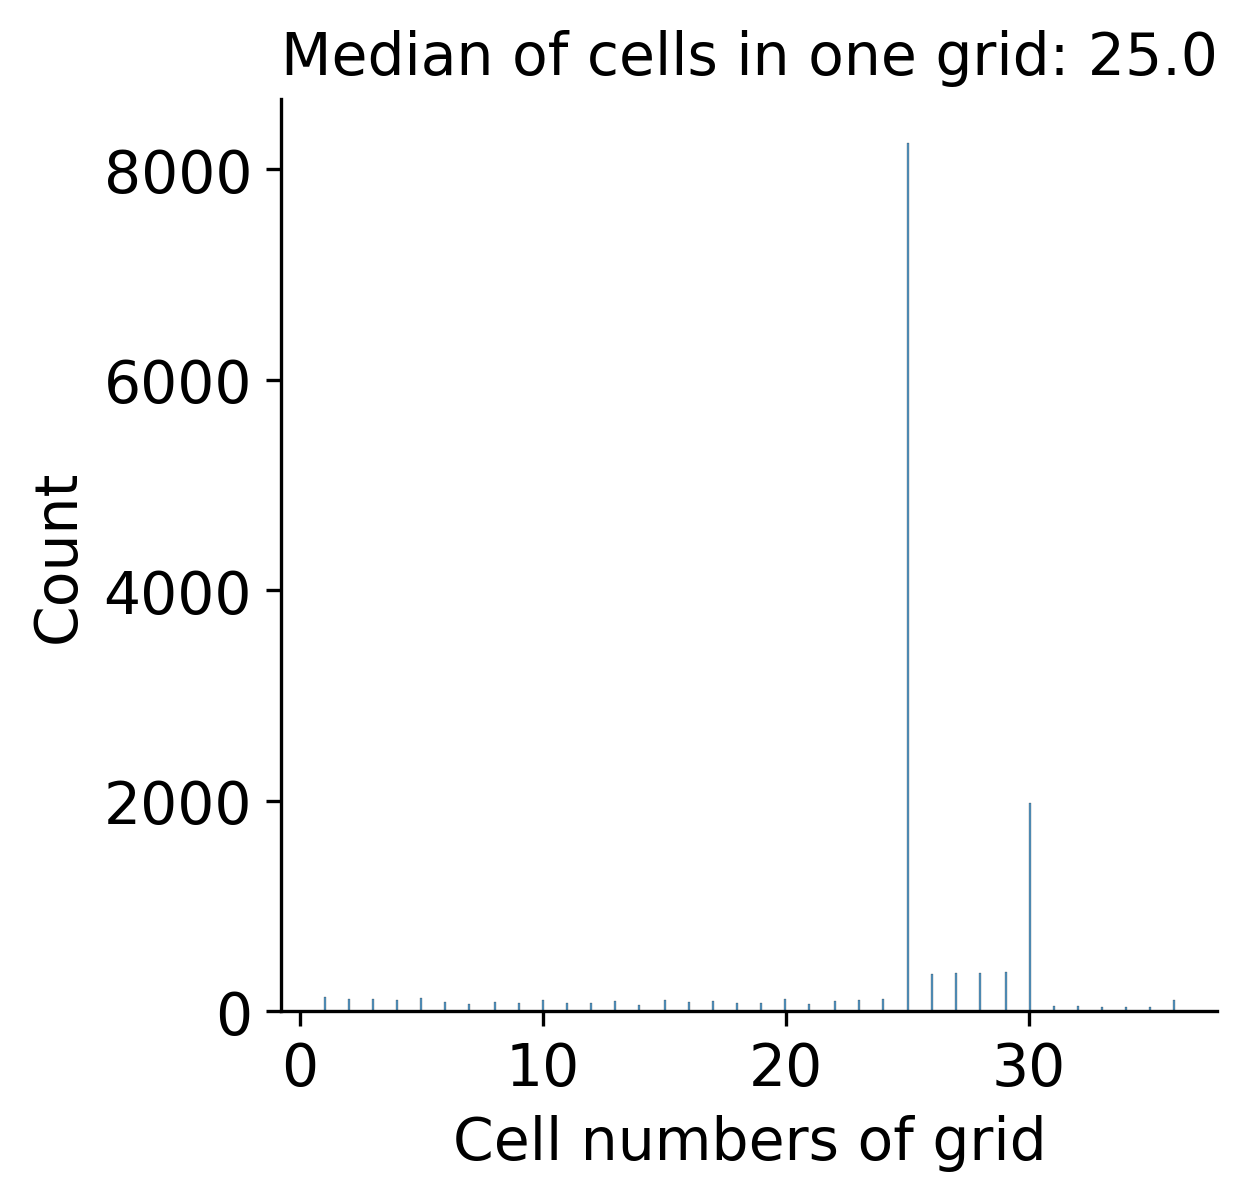

In [7]:
stdata_spot = py.generate_grid(stdata,width=150)

In [9]:
from time import time
start = time()
plmo_object = py.Polyomino(scdata,stdata_spot,cluster_time=0,device='cuda')
plmo_object.allocate()
end = time()
print(f'采样完成，耗时 {end - start:.2f} 秒')

Starting spot mapping.
Total loss: -1.670
Total loss: -1.874
Total loss: -1.889
Total loss: -1.893
Total loss: -1.894
Spot mapping completed.
Mapping matrix saved in zm.spot_matrix
采样完成，耗时 233.45 秒


In [ ]:
cell_alocated_data = py.sc2sc(scdata, stdata, plmo_object.spot_matrix,thres=0.1,method='max')

In [15]:
cell_alocated_data.uns = stdata.uns

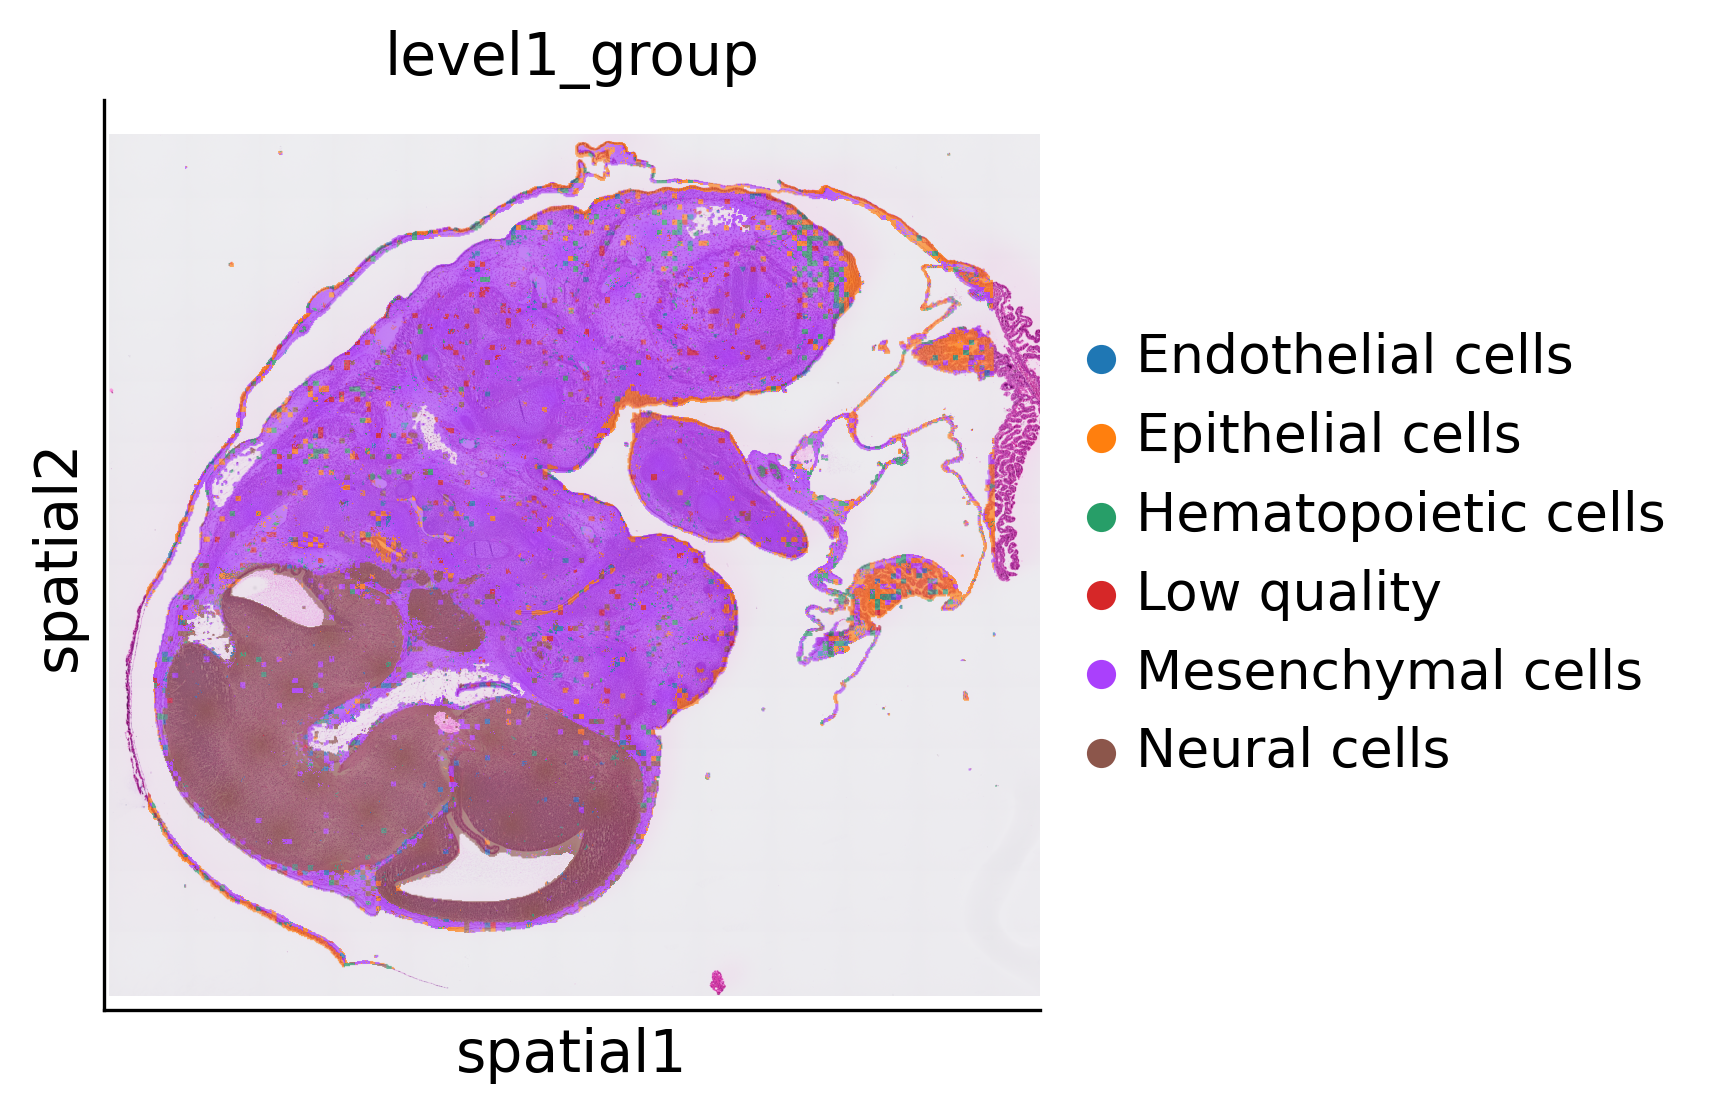

In [41]:
sc.pl.spatial(cell_alocated_data,color='level1_group')

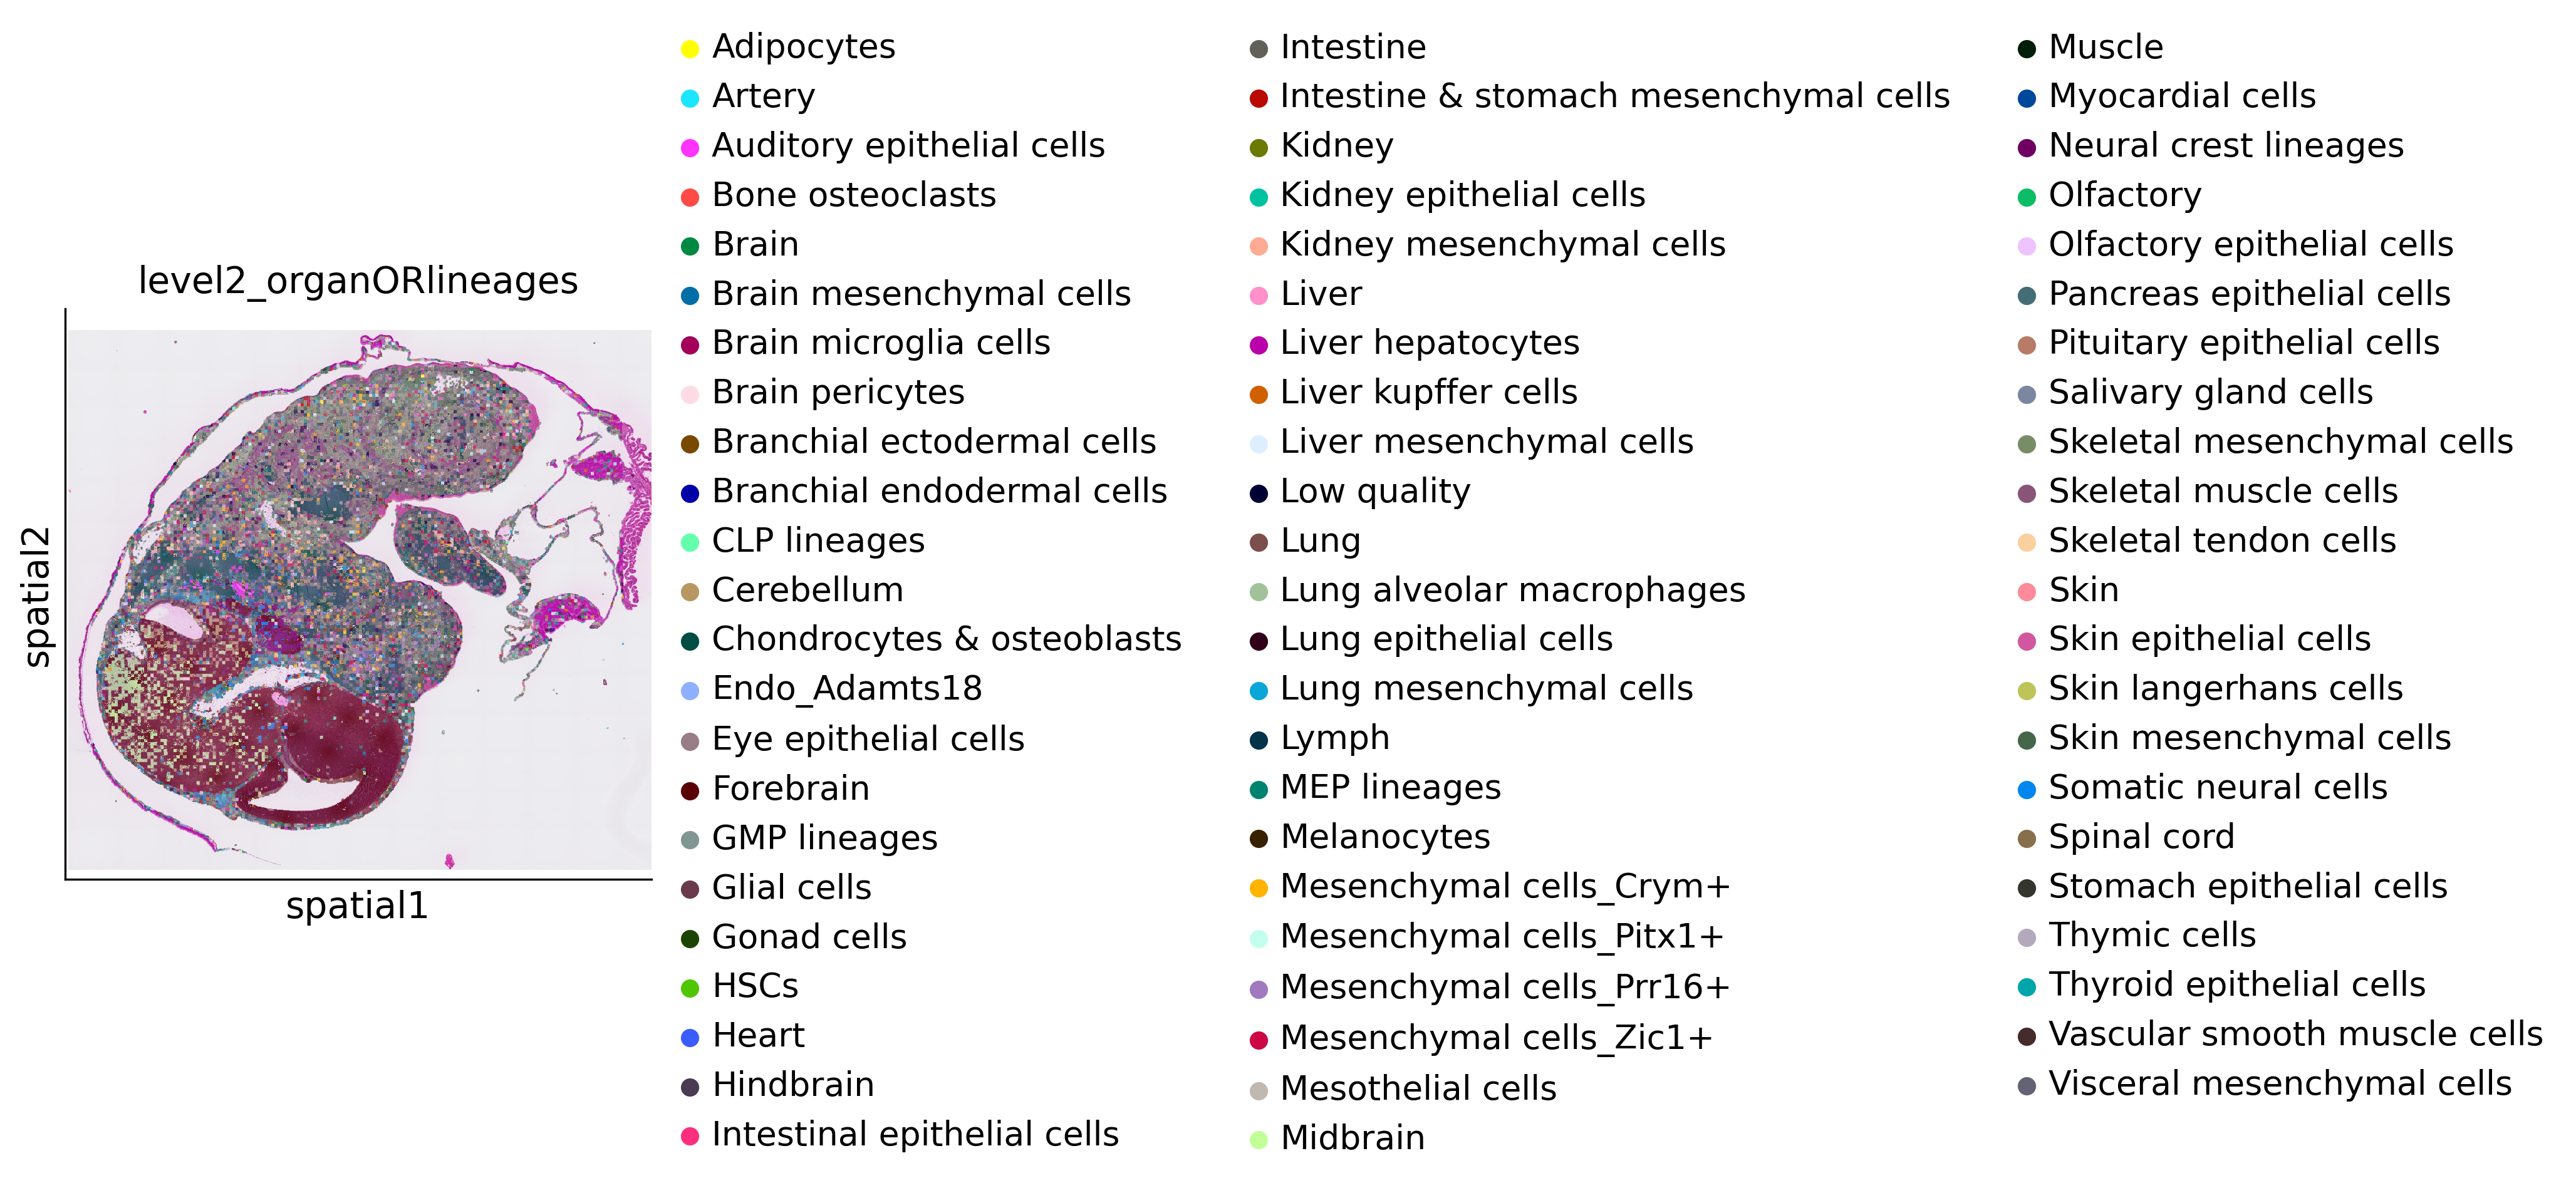

In [40]:
sc.pl.spatial(cell_alocated_data,color='level2_organORlineages')

In [48]:
import os
from PIL import Image

target_organs = ['Skin', 'Neural crest', 'Auditory organ', 'Brain', 'Bone', 'Liver']

# 创建保存文件夹
os.makedirs('spatial_per_organ', exist_ok=True)

# Step 1: 分别绘制并保存为 PNG
for organ in target_organs:
    sc.pl.spatial(
        cell_alocated_data,
        color='organ',
        groups=[organ],
        ncols=1,
        title=organ,
        show=False
    )
    plt.savefig(f'spatial_per_organ/{organ}.pdf', dpi=300, bbox_inches='tight')
    plt.close()

print('单个 organ 空间图已全部绘制并保存。')

# Step 2: 拼图并导出 PDF
from matplotlib.backends.backend_pdf import PdfPages

# 读取图片
image_files = [f'spatial_per_organ/{organ}.pdf' for organ in target_organs]
images = [Image.open(img) for img in image_files]

# 拼图参数
ncols = 3  # 每行子图数
nrows = int(np.ceil(len(images) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))
axes = axes.flatten()

for idx, img in enumerate(images):
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(target_organs[idx])

# 隐藏多余空子图
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()

# 输出 PDF
pdf = PdfPages('combined_spatial_plot.pdf')
pdf.savefig(fig)
pdf.close()

print('拼图已完成并导出为 combined_spatial_plot.pdf')

单个 organ 空间图已全部绘制并保存。


UnidentifiedImageError: cannot identify image file 'spatial_per_organ/Skin.pdf'